This notebook plots the NTD RBD and NTDRBD simulations with rU25 for each coronavirus ortholog

In [1]:
import seaborn as sns
import pandas as pd
from os.path import exists
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.pylab as pylab

from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
import matplotlib.ticker as ticker
%matplotlib inline

import scipy as scipy
from scipy import optimize

from soursop.sstrajectory import SSTrajectory
import mdtraj as md

import csv

import os

# define this so we can read in nucleotides
NA_EXTENSION = ['D5P', 'DPC',  'DPU',  'DPT',  'DPA',  'DPG',  'R5P',  'RPC' , 'RPU',  'RPT',  'RPA',  'RPG']

# molecular weight of N protein (g/mol)
MW_N = 18850
M2nM=1e9

# importing mean()
from statistics import mean
  
def Average(lst):
    return mean(lst)

import numpy as np

# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['legend.fontsize'] = 6

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Read in the Ka data

In [2]:
import pandas as pd
import glob
import os

pd.set_option('precision', 9)

path = r'./Analysis/Data/' # use your path
all_files = glob.glob(os.path.join(path , "*Ka.csv"))

Total = []

df = pd.concat((pd.read_csv(f) for f in all_files), axis = 1)

df = df.reindex(sorted(df.columns), axis=1)

df

,229E_229E_Ka,229E_NTD_Ka,229E_RBD_1_Ka,229E_RBD_2_Ka,229E_RBD_3_Ka,229E_RBD_4_Ka,229E_RBD_5_Ka,HKU1_HKU1_Ka,HKU1_NTD_Ka,HKU1_RBD_1_Ka,...,MHV1_RBD_3_Ka,MHV1_RBD_4_Ka,MHV1_RBD_5_Ka,SCO2_NTD_Ka,SCO2_RBD_1_Ka,SCO2_RBD_2_Ka,SCO2_RBD_3_Ka,SCO2_RBD_4_Ka,SCO2_RBD_5_Ka,SCO2_SCO2_Ka
0,0.000019779,0.000001455,0.000008765,0.000010746,0.000011535,0.000005679,0.000018842,0.000006044,0.000005377,0.000001996,...,0.000001205,0.000000802,0.000001041,0.000003061,0.000007096,0.000003403,0.000003620,0.000024642,0.000007247,0.000283194
1,0.000028850,0.000001327,0.000014588,0.000012300,0.000010599,0.000015103,0.000017279,0.000006355,0.000005451,0.000001554,...,0.000001343,0.000000649,0.000001075,0.000003370,0.000005627,0.000002736,0.000003589,0.000016679,0.000008436,0.000163364
2,0.000024727,0.000001325,0.000015348,0.000014985,0.000008976,0.000012669,0.000016113,0.000008733,0.000006568,0.000001746,...,0.000001306,0.000000745,0.000001181,0.000003027,0.000006257,0.000002845,0.000004561,0.000016720,0.000009883,0.000154271
3,0.000028836,0.000001359,0.000014770,0.000013288,0.000008127,0.000015363,0.000013972,0.000007936,0.000006261,0.000001482,...,0.000001438,0.000000918,0.000001186,0.000003118,0.000005417,0.000003102,0.000005635,0.000014754,0.000008367,0.000131777
4,0.000027367,0.000001387,0.000012929,0.000012136,0.000007252,0.000013253,0.000012464,0.000007498,0.000006281,0.000001466,...,0.000001422,0.000000986,0.000001216,0.000003687,0.000005740,0.000003054,0.000006866,0.000014609,0.000008035,0.000110627
5,0.000030711,0.000001406,0.000011701,0.000011368,0.000006669,0.000011847,0.000011458,0.000007862,0.000006294,0.000001456,...,0.000001412,0.000001032,0.000001236,0.000004066,0.000005956,0.000003022,0.000007687,0.000014512,0.000007813,0.000109958
6,0.000033542,NaN,NaN,NaN,NaN,NaN,NaN,0.000008510,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000102355
7,0.000034867,NaN,NaN,NaN,NaN,NaN,NaN,0.000008209,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000129754
8,0.000032412,NaN,NaN,NaN,NaN,NaN,NaN,0.000009885,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000133872
9,0.000031636,NaN,NaN,NaN,NaN,NaN,NaN,0.000011879,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000146117


In [3]:
df_transposed = df.T
df_transpindex = (df_transposed.index.values) 
#print(toes)
repeated = np.repeat(df_transpindex,20)
#print(repeated)
#print(df_transposed)

# Create an empty dictionary to store the grouped rows
grouped_rows = {}

# Iterate through the unique first 8 characters of the index
for index_prefix in df_transposed.index.str[:8].unique():
    # Find all indexes that match the current prefix
    matching_indexes = [index for index in df_transposed.index if index.startswith(index_prefix)]

    # Extract the corresponding rows and store them in the dictionary
    grouped_rows[index_prefix] = df_transposed.loc[matching_indexes].values.flatten()

# Create a new DataFrame using the dictionary
new_df = pd.DataFrame.from_dict(grouped_rows, orient='index')

new_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
229E_229,0.000019779,0.000028850,0.000024727,0.000028836,0.000027367,0.000030711,0.000033542,0.000034867,0.000032412,0.000031636,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
229E_NTD,0.000001455,0.000001327,0.000001325,0.000001359,0.000001387,0.000001406,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
229E_RBD,0.000008765,0.000014588,0.000015348,0.000014770,0.000012929,0.000011701,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HKU1_HKU,0.000006044,0.000006355,0.000008733,0.000007936,0.000007498,0.000007862,0.000008510,0.000008209,0.000009885,0.000011879,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HKU1_NTD,0.000005377,0.000005451,0.000006568,0.000006261,0.000006281,0.000006294,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HKU1_RBD,0.000001996,0.000001554,0.000001746,0.000001482,0.000001466,0.000001456,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MERS_MER,0.000012942,0.000018245,0.000013565,0.000013725,0.000013248,0.000012448,0.000011761,0.000014814,0.000015103,0.000014214,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MERS_NTD,0.000002880,0.000003768,0.000003256,0.000003341,0.000003455,0.000003532,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MERS_RBD,0.000002005,0.000001649,0.000001826,0.000002311,0.000002299,0.000002291,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MHV1_MHV,0.000022776,0.000016148,0.000015085,0.000020657,0.000020901,0.000022054,0.000021327,0.000019873,0.000018812,0.000017803,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
stacked = new_df.stack().to_frame()
stacked

0
229E_229 0   0.000019779
         1   0.000028850
         2   0.000024727
         3   0.000028836
         4   0.000027367
...                  ...
SCO2_SCO 15  0.000148702
         16  0.000151084
         17  0.000144535
         18  0.000140296
         19  0.000136372

[280 rows x 1 columns]

In [5]:
# Reset the index to create a new column for the first 8 characters of the old index
new_df_reset = new_df.stack().to_frame().reset_index()

# Calculate the mean of all values with index 'SCO2_SCO2'
mean_sco2 = new_df_reset.loc[new_df_reset['level_0'] == 'SCO2_SCO', 0].mean()
print(mean_sco2)
# Create the new column 'Ka*' by dividing column '0' by the mean of 'SCO2_SCO2'
new_df_reset['Ka*'] = new_df_reset[0] / mean_sco2

print(new_df_reset)

0.00014456399135087002
      level_0  level_1            0          Ka*
0    229E_229        0  0.000019779  0.136820289
1    229E_229        1  0.000028850  0.199565048
2    229E_229        2  0.000024727  0.171045693
3    229E_229        3  0.000028836  0.199471309
4    229E_229        4  0.000027367  0.189307977
..        ...      ...          ...          ...
275  SCO2_SCO       15  0.000148702  1.028624883
276  SCO2_SCO       16  0.000151084  1.045104046
277  SCO2_SCO       17  0.000144535  0.999798829
278  SCO2_SCO       18  0.000140296  0.970478648
279  SCO2_SCO       19  0.000136372  0.943331689

[280 rows x 4 columns]


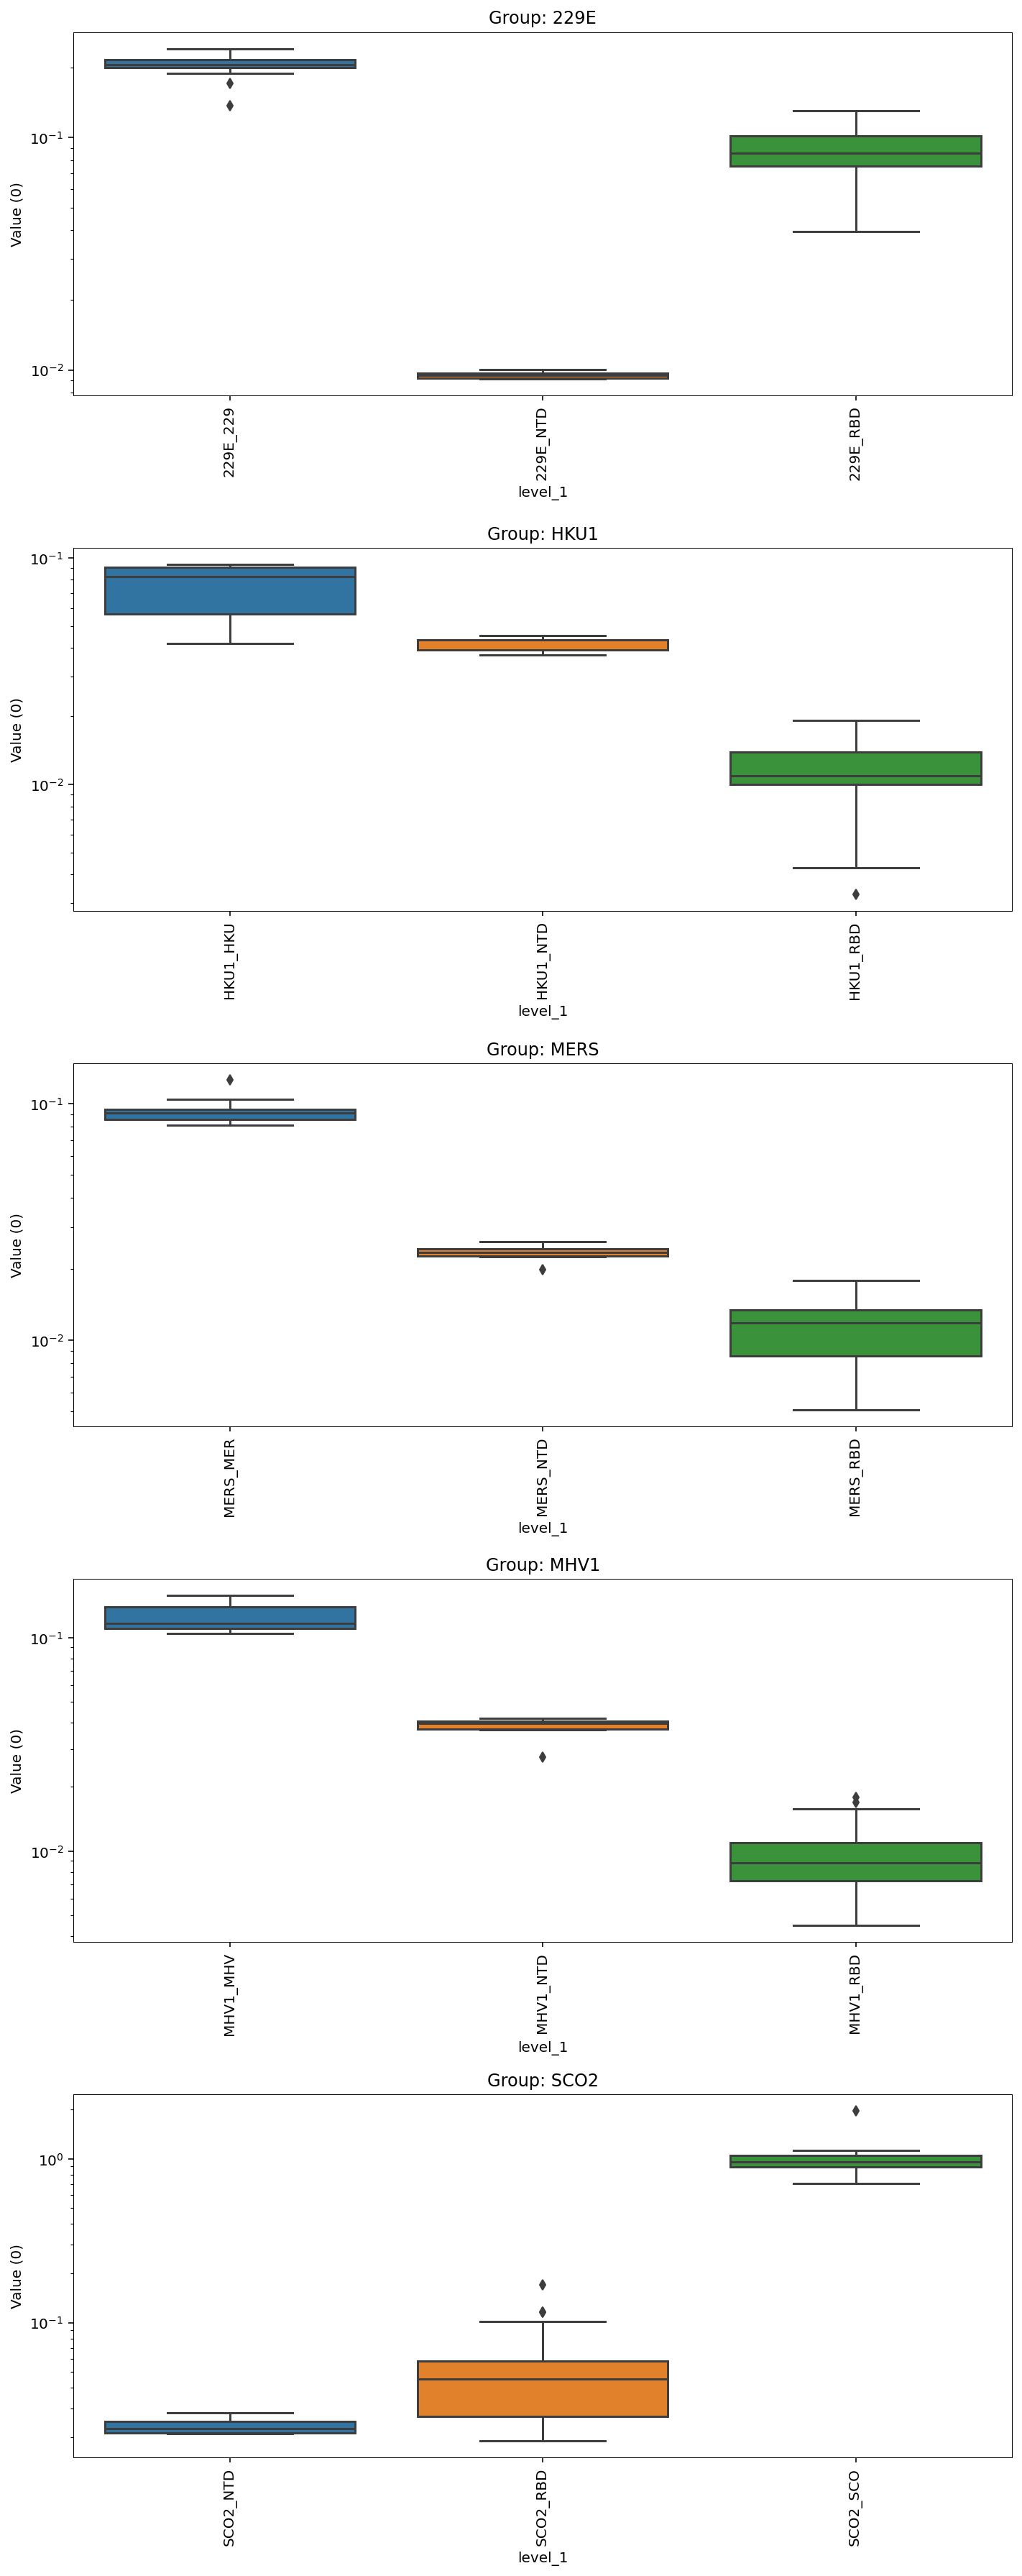

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot each ortholog individually
# Group the DataFrame based on the first 4 characters in 'level_0'
grouped_df = new_df_reset.groupby(new_df_reset['level_0'].str[:4])

# Get the number of unique groups
num_groups = len(grouped_df)

# Set up subplots
fig, axes = plt.subplots(nrows=num_groups, ncols=1, figsize=(10, 5*num_groups))

# Plot individual scatter plots for each group
for i, (group_name, group_data) in enumerate(grouped_df):
    if len(group_data) > 0:  # Only plot if there are values in the group
        sns.boxplot(ax=axes[i], x='level_0', y='Ka*', data=group_data)
        axes[i].set_title(f'Group: {group_name}')
        axes[i].set_xlabel('level_1')
        axes[i].set_ylabel('Value (0)')

        # Set the y-axis to a logarithmic scale
        axes[i].set_yscale('log')

        # Rotate the x-axis labels for better visibility
        axes[i].tick_params(axis='x', rotation=90)
        plt.savefig('{group_name}.pdf')
plt.tight_layout()
plt.show()


